In [1]:
!pip install patchify

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import glob

from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler =  MinMaxScaler()

In [4]:
!ls -lah '/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR/label_as_png'

total 0
drwxr-xr-x 4 nobody nogroup 0 Mar  9 15:44  .
drwxr-xr-x 3 nobody nogroup 0 Mar  9 15:44  ..
drwxr-xr-x 4 nobody nogroup 0 Mar  9 15:44 'tile 1'
drwxr-xr-x 4 nobody nogroup 0 Mar  9 15:44 'tile 2'


In [5]:
dataset_root_folder = '/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR'

In [6]:
dataset_name = 'label_as_png'

In [7]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
    dir_name = path.split(os.path.sep)[-1]
    #print(dir_name)
    if dir_name == 'masks' : # 'images':
      images = os.listdir(path)
      print(path)
      #print(images)
      for i, image_name in enumerate (images):
        if (image_name.endswith('.png')):
          #print(image_name)
          a = True


/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR/label_as_png/tile 2/masks
/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR/label_as_png/tile 1/masks


In [8]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks':
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')):
        #print(image_name)
        a = True

/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR/label_as_png/tile 2/masks
/kaggle/input/tugas-akhir-hrts/TUGAS AKHIR/label_as_png/tile 1/masks


In [9]:
image_patch_size = 128

In [10]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/tile 2/images/image_1.png',1)

In [11]:
image.shape

(469, 343, 3)

In [12]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [13]:
len(image_patches)

3

In [14]:
print(image_patches.shape)

(3, 2, 1, 128, 128, 3)


In [15]:
minmaxscaler =  MinMaxScaler()

In [16]:
image_x = image_patches[0,0,:,:,:]
#MinMaxScaler
minmaxscaler = MinMaxScaler()
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [17]:
image_y[0].shape

(128, 128, 3)

In [18]:
print(type(image))

<class 'numpy.ndarray'>


In [19]:
try:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image)
    print("Berhasil membuat PIL image:", type(pil_image))
except Exception as e:
    print("Error saat membuat PIL image:", e)

Berhasil membuat PIL image: <class 'PIL.Image.Image'>


In [20]:
image.shape

(469, 343, 3)

In [21]:
(image.shape[0]//image_patch_size)*image_patch_size

384

In [22]:
image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    for tile_id in range(1, 2):  # Pastikan tile_id ada
        for image_id in range(1, 1000):  # Looping untuk semua gambar
            
            # Cek apakah ini gambar atau mask
            if image_type == 'images':
                path = f'{dataset_root_folder}/{dataset_name}/tile {tile_id}/images/image_{image_id}.png'
            else:  # image_type == 'masks'
                path = f'{dataset_root_folder}/{dataset_name}/tile {tile_id}/masks/label_image_{image_id}.png'

            # Baca gambar
            image = cv2.imread(path, cv2.IMREAD_COLOR)
            if image is None:
                print(f"Skipping {path} - Not found")
                continue  # Lewati jika file tidak ditemukan

            # Jika mask, ubah ke RGB
            if image_type == 'masks':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Pastikan ukuran sesuai patch size
            size_x = (image.shape[1] // image_patch_size) * image_patch_size
            size_y = (image.shape[0] // image_patch_size) * image_patch_size
            
            if size_x == 0 or size_y == 0:
                print(f"Skipping {image_patch_size} - Image too small for patch size")
                continue
            
            # Crop gambar agar pas dengan patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, size_x, size_y))
            image = np.array(image)

            # Bagi gambar menjadi patch
            patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

            # Simpan patch gambar/mask ke dataset
            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_patch = patched_images[i, j, :, :]
                    
                    if image_type == 'images':
                        individual_patch = minmaxscaler.fit_transform(individual_patch.reshape(-1, individual_patch.shape[-1])).reshape(individual_patch.shape)
                        individual_patch = (individual_patch * 255).astype(np.uint8)
                        image_dataset.append(individual_patch)
                    else:  # image_type == 'masks'
                        individual_patch = individual_patch[0]  # Ambil layer pertama
                        mask_dataset.append(individual_patch)
                        
                        individual_patched_mask = patched_images[i, j, :, :]  # Pastikan variabel ini selalu dibuat
                        label = individual_patched_mask

Skipping 128 - Image too small for patch size
Skipping 128 - Image too small for patch size
Skipping 128 - Image too small for patch size
Skipping 128 - Image too small for patch size
Skipping 128 - Image too small for patch size
Skipping 128 - Image too small for patch size


In [23]:
print(len(image_dataset))
print(len(mask_dataset))

12084
12084


In [24]:
image_dataset = np.array(image_dataset, dtype=np.uint8)
mask_dataset = np.array(mask_dataset, dtype=np.uint8)

In [25]:
print(len(image_dataset))
print(len(mask_dataset))

12084
12084


In [26]:
type(np.reshape(image_dataset[0], (image_patch_size, image_patch_size, 3)))

numpy.ndarray

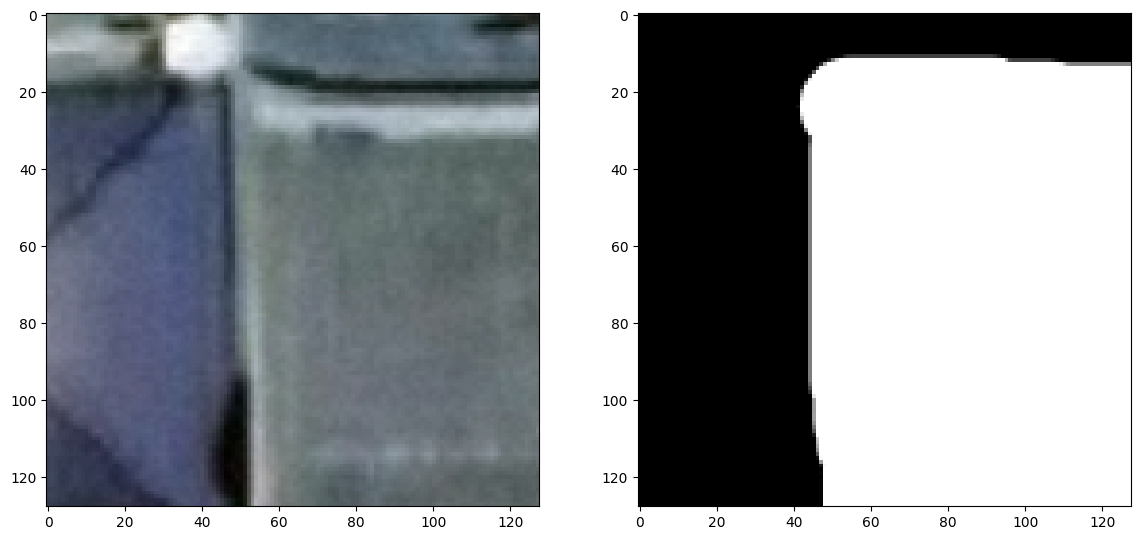

In [27]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[random_image_id].squeeze())
plt.subplot(1,2,2)
plt.imshow(mask_dataset[random_image_id].squeeze())

In [28]:
# Pastikan library sudah terinstal
!pip install scikit-image  # Install scikit-image jika belum terinstal

import os
import numpy as np
from skimage import io  # Import modul 'io' dari scikit-image

# Parameter dataset
dataset_root_folder = '/kaggle/input/tugas-akhir/TUGAS AKHIR'
dataset_name = "label_as_png"

# List untuk menyimpan dataset
labeled_data = []  # List untuk menyimpan mask dan labelnya

# Fungsi untuk membaca mask dari tile tertentu dan memberikan label
def process_tile(tile_id, label):
    masks_folder = f"{dataset_root_folder}/{dataset_name}/tile {tile_id}/masks/"
    
    if not os.path.exists(masks_folder):
        print(f"Folder tidak ditemukan: {masks_folder}")
        return []
    
    print(f"Processing masks from: {masks_folder}")  # Debug: Print folder path

    tile_masks = []  # List untuk menyimpan mask dari tile tertentu
    for filename in os.listdir(masks_folder):
        if filename.endswith(".png"):  # Pastikan hanya membaca file PNG
            print(filename)  # Debug: Print nama file yang ditemukan
            mask_path = os.path.join(masks_folder, filename)  # Buat path lengkap ke file
            mask = io.imread(mask_path)  # Baca file menggunakan skimage.io
            mask = np.where(mask > 1, 1, 0)  # Binarisasi mask
            tile_masks.append((mask, label))  # Simpan mask dan label dalam tuple
    return tile_masks

# Proses tile 1 untuk bangunan teratur
regularity_building_data = process_tile(tile_id=1, label="Regularity_Building")

# Proses tile 2 untuk bangunan tidak teratur
irregularity_building_data = process_tile(tile_id=2, label="Irregularity_Building")

# Gabungkan data dari kedua tile
labeled_data.extend(regularity_building_data)
labeled_data.extend(irregularity_building_data)

# Debug: Print jumlah dataset yang dihasilkan
print(f"Jumlah dataset: {len(labeled_data)}")
print(f"Contoh data: {labeled_data[:2]}")  # Print contoh 2 data pertama


Folder tidak ditemukan: /kaggle/input/tugas-akhir/TUGAS AKHIR/label_as_png/tile 1/masks/
Folder tidak ditemukan: /kaggle/input/tugas-akhir/TUGAS AKHIR/label_as_png/tile 2/masks/
Jumlah dataset: 0
Contoh data: []


In [29]:
mask_dataset.shape[0]

12084

In [30]:
label = individual_patched_mask

In [31]:
def rgb_to_label(labeled_data):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    print(label_segment.shape)
    label_segment = 1
    return label_segment

In [32]:
def rgb_to_label(labeled_data):
    label_segment = np.zeros(labeled_data.shape[:2], dtype=np.uint8)
    label_segment[np.all(labeled_data == regularity_building_data, axis=-1)] = 0  # Bangunan Tidak Teratur = 0
    label_segment[np.all(labeled_data == irregularity_building_data, axis=-1)] = 1  # Bangunan Teratur = 1
    #print(label_segment)
    label_segment = label_segment[:,:,0]
    #print(label_segment)
    return label_segment

In [33]:
def rgb_to_label(labeled_data):
    label_segment = np.zeros(labeled_data.shape[:2], dtype=np.uint8)
    label_segment[np.all(labeled_data == regularity_building_data, axis=-1)] = 0  # Bangunan Tidak Teratur = 0
    label_segment[np.all(labeled_data == irregularity_building_data, axis=-1)] = 1  # Bangunan Teratur = 1
    return label_segment

In [34]:
import numpy as np

# Definisi warna RGB untuk setiap kategori
regularity_Building = np.array([255, 255, 255])   
irregularity_Building = np.array([0, 0, 0])  

def rgb_to_label(labeled_data):
    labeled_data = labeled_data.astype(np.uint8)
    """Mengonversi gambar mask RGB menjadi label biner (0 dan 1)."""
    label_segment = np.zeros(labeled_data.shape, dtype=np.uint8)  # Pastikan hanya H x W
    
    # Bandingkan piksel dengan warna yang sudah didefinisikan
    label_segment[np.all(labeled_data == regularity_Building, axis=-1)] = 0  # Bangunan Tidak Teratur
    label_segment[np.all(labeled_data == irregularity_Building, axis=-1)] = 1  # Bangunan Teratur
    #print(label_segment)
    label_segment = label_segment[:,:,0]
    #print(label_segment)
    return label_segment

In [35]:
labels = []
for i in range(mask_dataset.shape[0]):
    labeled_data = rgb_to_label (mask_dataset[i])
    labels.append(labeled_data)

In [36]:
print(len(labels))

12084


In [37]:
labels = np.array(labels)

In [38]:
labels[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [39]:
labels = np.expand_dims(labels, axis=3)

In [40]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [41]:
np.unique(labels)

array([0, 1], dtype=uint8)

In [42]:
print("Total unique labels based on masks"),(np.unique(labels))

Total unique labels based on masks


(None, array([0, 1], dtype=uint8))

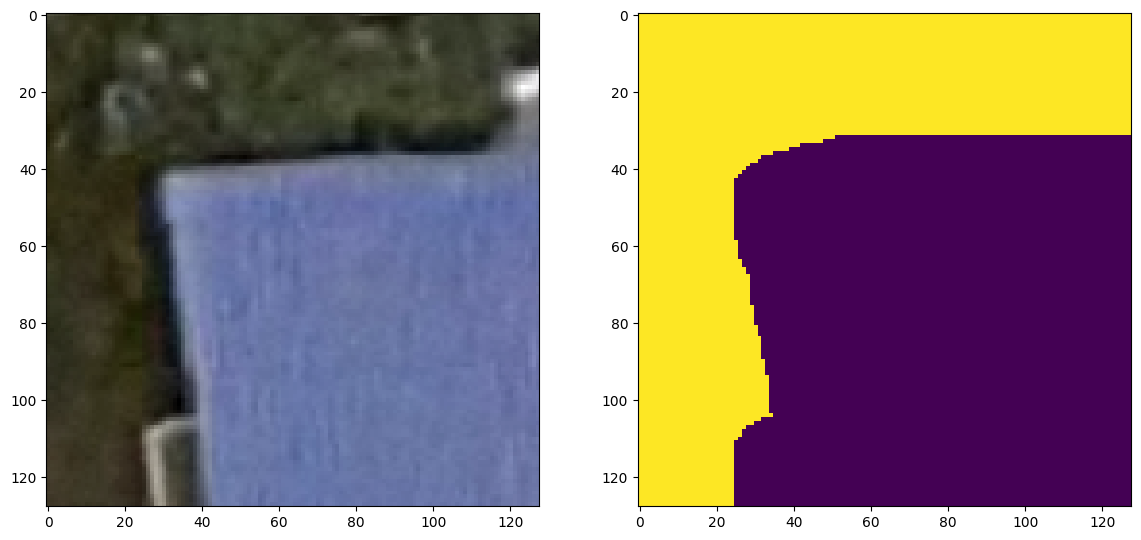

In [43]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(image_dataset[random_image_id].squeeze())
plt.subplot(1,2,2)
#plt.imshow(mask_dataset[random_image_id].squeeze())
plt.imshow(labels[random_image_id][:,:,0])

In [44]:
    labels[0][:,:,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [45]:
total_classes = len(np.unique(labels))

In [46]:
total_classes

2

In [47]:
from tensorflow.keras.utils import to_categorical

In [48]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [49]:
labels_categorical_dataset.shape

(12084, 128, 128, 2)

In [50]:
master_training_dataset = image_dataset

In [51]:
master_training_dataset = np.squeeze(master_training_dataset, axis=1)
print(master_training_dataset.shape)

(12084, 128, 128, 3)


In [52]:
master_training_dataset.shape

(12084, 128, 128, 3)

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.10, random_state=100)

In [55]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10875, 128, 128, 3)
(1209, 128, 128, 3)
(10875, 128, 128, 2)
(1209, 128, 128, 2)


In [56]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
total_classes = y_train.shape[3]

In [57]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
2


In [58]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [59]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [60]:
from keras import backend as K

In [61]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum (y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [62]:
def multi_unet_model(n_classes=2, image_height=128, image_width=128, image_channels=3):
    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    # Decoder
    u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [63]:
metrics = ["accuracy", jaccard_coef]

In [64]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
2


In [65]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [66]:
model = get_deep_learning_model()

In [67]:
# Please uncomment this line to get model confiuration
# model.get_config()

In [68]:
model.get_config()

{'name': 'functional',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None,
   'name': 'input_layer',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'clas

In [69]:
weights = [0.5, 0.5]  # Untuk binary segmentation

In [70]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [71]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [72]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [73]:
total_loss = dice_loss + (1 * focal_loss)

In [74]:
import tensorflow as tf

In [75]:
import tensorflow.keras.backend as K

In [76]:
tf.keras.backend.clear_session()

In [77]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=metrics)

In [78]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 8)    │            224 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 8)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 8)    │            584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 8)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 16)     │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 16)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 16)     │          2,320 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 16)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 32)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 32)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 64)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 64)       │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 485,826 (1.85 MB)

 Trainable params: 485,826 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)
datagen.fit(x_train)  # Augmentasi data latih


In [80]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callback untuk Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)

# Callback untuk Reduce Learning Rate saat stagnan
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Training Model dengan callback
model_history = model.fit(
    x_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=50,
    validation_data=(x_test, y_test),
    shuffle=True,  # ⬅️ Pastikan data tidak urut tetap
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 46s 82ms/step - accuracy: 0.5463 - jaccard_coef: 0.3319 - loss: 4.9123 - val_accuracy: 0.5892 - val_jaccard_coef: 0.3427 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5746 - jaccard_coef: 0.3421 - loss: 0.6890 - val_accuracy: 0.5938 - val_jaccard_coef: 0.3470 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5784 - jaccard_coef: 0.3452 - loss: 0.6834 - val_accuracy: 0.5939 - val_jaccard_coef: 0.3473 - val_loss: 0.6754 - learning_rate: 0.0010
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5835 - jaccard_coef: 0.3465 - loss: 0.6806 - val_accuracy: 0.6006 - val_jaccard_coef: 0.3488 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 5/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7608 - jaccard_coef: 0.4988 - loss: 0.5012 - val_accuracy: 0.7360 - val_jaccard_coef: 0.4526 - val_loss: 0.5313 - le

In [81]:
history_a = model_history

In [82]:
history_a.history

{'accuracy': [0.5671678185462952,
  0.5788272023200989,
  0.5808075666427612,
  0.5838780403137207,
  0.5890348553657532,
  0.5960699319839478,
  0.612917423248291,
  0.6361440420150757,
  0.6592679023742676,
  0.702887773513794,
  0.7203357815742493,
  0.7299426794052124,
  0.7400729060173035,
  0.7459681034088135,
  0.7519083023071289,
  0.7555971741676331,
  0.7605295181274414,
  0.7664482593536377,
  0.7682700157165527,
  0.7715446949005127,
  0.7748609185218811,
  0.7811461091041565,
  0.781846284866333,
  0.7823886275291443,
  0.7844434380531311,
  0.7898510098457336,
  0.7915987968444824,
  0.7951308488845825,
  0.7941111922264099,
  0.8008821606636047,
  0.8022040128707886,
  0.8056325316429138,
  0.8221481442451477,
  0.826386034488678,
  0.8304181694984436,
  0.8311241269111633,
  0.8336312174797058],
 'jaccard_coef': [0.3375883102416992,
  0.3434085249900818,
  0.34542033076286316,
  0.3467213213443756,
  0.3480229675769806,
  0.3503040075302124,
  0.3558882474899292,
  0.36

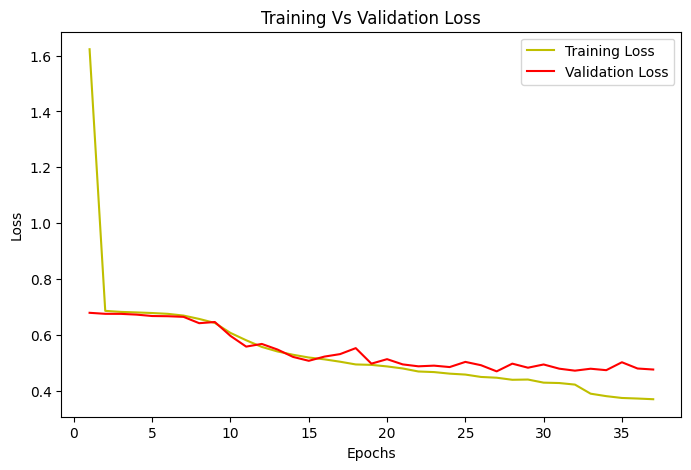

In [83]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

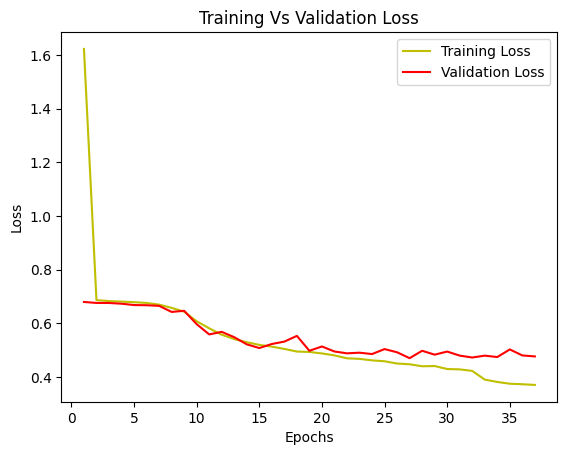

In [84]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

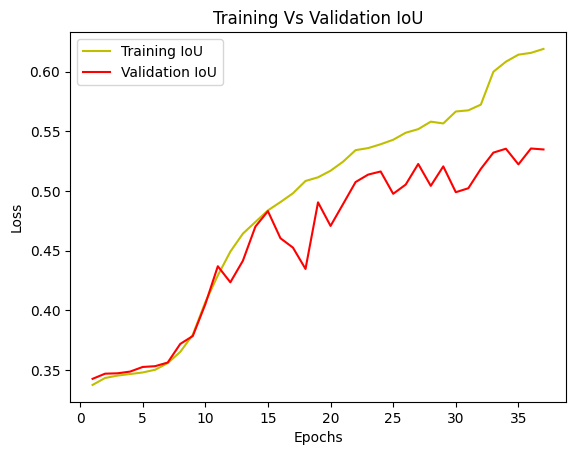

In [85]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [86]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 340}

In [87]:
y_pred = model.predict(x_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [88]:
len(y_pred)

1209

In [89]:
y_pred

array([[[[0.5973459 , 0.40265408],
         [0.5475452 , 0.45245484],
         [0.53556895, 0.46443105],
         ...,
         [0.74971676, 0.2502832 ],
         [0.7506872 , 0.24931282],
         [0.7468727 , 0.25312728]],

        [[0.4835092 , 0.5164908 ],
         [0.48809907, 0.5119009 ],
         [0.49006593, 0.50993407],
         ...,
         [0.7538825 , 0.2461174 ],
         [0.7670475 , 0.23295254],
         [0.75866985, 0.24133015]],

        [[0.4368075 , 0.5631925 ],
         [0.44791365, 0.55208635],
         [0.48697373, 0.5130263 ],
         ...,
         [0.7400189 , 0.2599811 ],
         [0.7680546 , 0.23194537],
         [0.76412815, 0.23587187]],

        ...,

        [[0.3642414 , 0.6357586 ],
         [0.38305616, 0.61694384],
         [0.3644836 , 0.6355164 ],
         ...,
         [0.69713706, 0.3028629 ],
         [0.7480911 , 0.2519089 ],
         [0.70240253, 0.29759747]],

        [[0.34985033, 0.65014964],
         [0.33356357, 0.6664365 ],
         [0.

In [90]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [91]:
len(y_pred_argmax)

1209

In [92]:
y_pred_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 

In [93]:
y_test_argmax = np.argmax(y_test, axis=3)

In [94]:
y_test_argmax

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [121]:
import random

In [122]:
test_image_number = random.randint(0, len(x_test))

test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


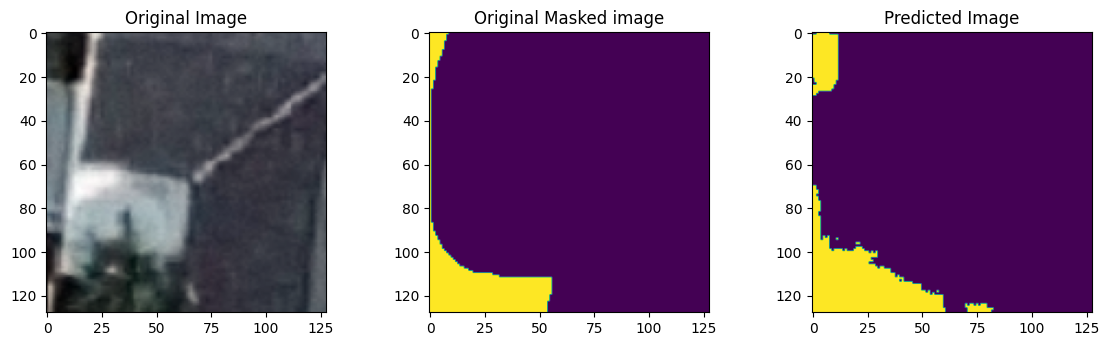

In [123]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [98]:
y_test_flat = np.argmax(y_test, axis=3).flatten()  # Mengambil argmax pada dimensi terakhir untuk y_test
y_pred_flat = y_pred_argmax.flatten()  # Meratakan y_pred_argmax

# Evaluasi ulang classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_flat, y_pred_flat, digits=2))



              precision    recall  f1-score   support

           0       0.76      0.89      0.82  11653190
           1       0.80      0.60      0.68   8155066

    accuracy                           0.77  19808256
   macro avg       0.78      0.74      0.75  19808256
weighted avg       0.77      0.77      0.76  19808256



In [99]:
model.save("semantic_segmentation_irregularity_and_regularity_building.h5")

In [128]:
import numpy as np

# Simpan history sebagai NumPy array
np.save('/kaggle/working/training_history_irregularity_semantic.npy', history_a.history)


In [100]:
!ls -lah 

total 5.8M
drwxr-xr-x 3 root root 4.0K Mar  9 15:57 .
drwxr-xr-x 5 root root 4.0K Mar  9 15:44 ..
-rw-r--r-- 1 root root 5.8M Mar  9 15:57 semantic_segmentation_irregularity_and_regularity_building.h5
drwxr-xr-x 2 root root 4.0K Mar  9 15:44 .virtual_documents


In [101]:
from keras.models import load_model 

In [102]:
from tensorflow.keras.losses import Loss

class CustomLoss(Loss):
    def call(self, y_true, y_pred):
        return total_loss(y_true, y_pred)

    def get_config(self):
        return {}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

saved_model = load_model('/kaggle/working/semantic_segmentation_irregularity_and_regularity_building.h5',
                         custom_objects={'dice_loss_plus_1focal_loss': CustomLoss,  # tanpa tanda kurung ()
                                         'jaccard_coef': jaccard_coef})

saved_model.compile(optimizer="adam", loss=total_loss, metrics=['accuracy'])
print(saved_model.loss.name)  # ✅ Harusnya berhasil

dice_loss_plus_1focal_loss


In [103]:
saved_model = load_model('/kaggle/working/semantic_segmentation_irregularity_and_regularity_building.h5',
                         custom_objects={'dice_loss_plus_1focal_loss': CustomLoss,  # tanpa tanda kurung ()
                                         'jaccard_coef': jaccard_coef})

In [104]:
saved_model.compile(optimizer="adam", loss=total_loss, metrics=['accuracy'])
print(saved_model.loss.name)  # ✅ Harusnya berhasil

dice_loss_plus_1focal_loss


In [105]:
model = saved_model
model.loss.name

'dice_loss_plus_1focal_loss'

In [106]:
#saved_model.get_config()

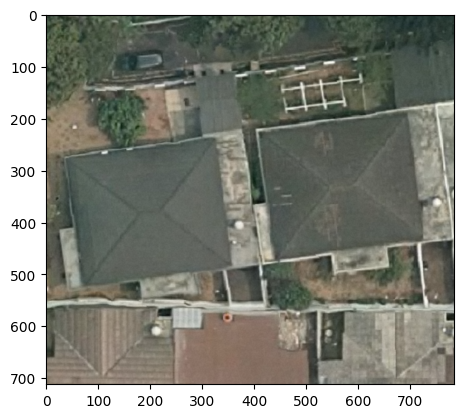

In [107]:
plt.imshow(Image.open("/kaggle/input/prediction-imagee/Predicted_1.png"))

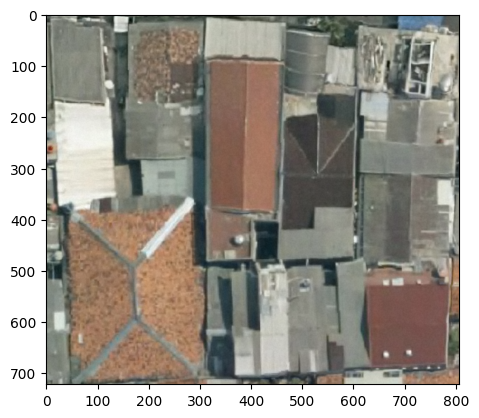

In [108]:
plt.imshow(Image.open("/kaggle/input/prediction-imagee/Predicted_2.png"))

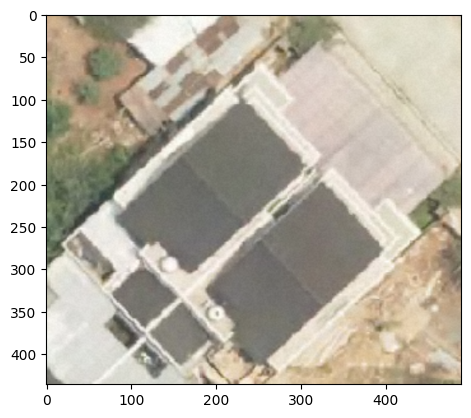

In [132]:
plt.imshow(Image.open("/kaggle/input/prediksi-teratur/image_61.png"))

In [133]:
from PIL import Image
import numpy as np

image = Image.open('/kaggle/input/prediksi-teratur/image_61.png')
image = image.convert("RGB")  
image = image.resize((128, 128))

image = np.array(image) / 255

print("Shape after conversion:", image.shape)

image = np.expand_dims(image, axis=0)  # Tambah batch dimension

prediction = saved_model.predict(image)

Shape after conversion: (128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [134]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

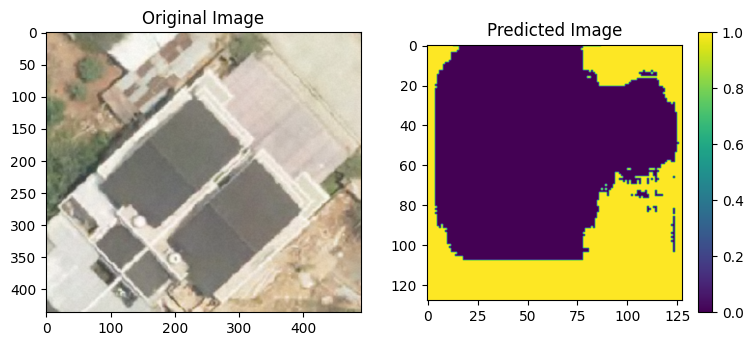

In [135]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/kaggle/input/prediksi-teratur/image_61.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.colorbar()
plt.show()


# plt.figure(figsize=(20,12))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/kaggle/input/prediction-imagee/Predicted_2.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)